# Machine Learning I

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,StratifiedKFold, cross_val_score, train_test_split
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
#read data scikit-learn
os.chdir('C:/Users/Katharina/Desktop/Weiterbildung/Bootcamp/Bootcamp/Final_project/data')
#data = pd.read_csv('DatenML_V2_relCol.csv', sep=';')
data = pd.read_csv('DatenML_V2_relCol_ZusatzType.csv', sep=';')	

In [27]:
y = data.pop('match_win')
X = data.copy()

In [ ]:
#in teamfault auch vier NAs -> imputieren

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

### Encoding

In [32]:
# select categorical and numerical column names
nominal_features = X.select_dtypes(include=['object']).columns.tolist()
# Define feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [35]:
# Create preprocessors for different feature types
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Build the column transformer
transformers = [
    ('num', numeric_transformer, numeric_features),
    ('nom', nominal_transformer, nominal_features)
]

In [36]:
preprocessor = ColumnTransformer(transformers=transformers)


In [39]:
#Model Building
# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, 
                                         min_samples_split=5, min_samples_leaf=2),
    'GradientBoosting': GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                 max_depth=5, subsample=0.8)
}

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)





In [41]:

# Function to train and evaluate models
def evaluate_model(name, model, X, y, cv):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    
    print(f"{name} - Cross-validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train on full dataset for feature importance
    pipeline.fit(X, y)
    
    return pipeline

In [42]:
# Evaluate all models
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = evaluate_model(name, model, X, y, cv)
    trained_models[name] = pipeline


Training RandomForest...
RandomForest - Cross-validation Accuracy: 0.9450 (±0.0061)

Training GradientBoosting...
GradientBoosting - Cross-validation Accuracy: 0.9981 (±0.0010)


In [ ]:
# # ==============================================
# # Create Ensemble Model
# # ==============================================
# print("\nCreating ensemble model...")

# # Create a voting classifier
# voting_clf = VotingClassifier(
#     estimators=[
#         ('rf', Pipeline([('preprocessor', preprocessor), ('classifier', models['RandomForest'])])),
#         ('gb', Pipeline([('preprocessor', preprocessor), ('classifier', models['GradientBoosting'])]))
#     ],
#     voting='soft'
# )

# # Evaluate voting classifier
# voting_scores = cross_val_score(voting_clf, X, y, cv=cv, scoring='accuracy')
# print(f"Voting Classifier - Cross-validation Accuracy: {voting_scores.mean():.4f} (±{voting_scores.std():.4f})")

# # Create stacking classifier
# stacking_clf = StackingClassifier(
#     estimators=[
#         ('rf', Pipeline([('preprocessor', preprocessor), ('classifier', models['RandomForest'])])),
#         ('gb', Pipeline([('preprocessor', preprocessor), ('classifier', models['GradientBoosting'])]))
#     ],
#     final_estimator=LogisticRegression(),
#     cv=cv
# )
# # Evaluate stacking classifier
# stacking_scores = cross_val_score(stacking_clf, X, y, cv=cv, scoring='accuracy')
# print(f"Stacking Classifier - Cross-validation Accuracy: {stacking_scores.mean():.4f} (±{stacking_scores.std():.4f})")

# # Train the ensemble model on the full training set
# print("\nTraining final ensemble model on full dataset...")
# stacking_clf.fit(X, y)

In [47]:
# ==============================================
# Feature Importance Analysis
# ==============================================
print("\nAnalyzing feature importance...")

# Get feature importance from one of the tree-based models (e.g., Random Forest)
rf_model = trained_models['RandomForest']
preprocessed_X = rf_model.named_steps['preprocessor'].transform(X)





Analyzing feature importance...



Top 20 most important features:
                    Feature  Importance
5                ServeTotal    0.138991
1                SpikeFault    0.107168
2                SpikePoint    0.062836
6                BlockPoint    0.059586
4                ServePoint    0.043665
9            ReceptionFault    0.039610
27                  total_B    0.035434
26                  total_A    0.035006
5301      TeamDesignation_A    0.032662
10               SpikeTotal    0.029151
5303      TeamDesignation_B    0.027709
7                BlockTotal    0.024502
11         @PointsTeamASet1    0.019882
14         @PointsTeamBSet2    0.017943
16         @PointsTeamBSet3    0.014434
5304  TeamDesignation_B / A    0.013655
5302  TeamDesignation_A / B    0.012799
12         @PointsTeamBSet1    0.011813
15         @PointsTeamASet3    0.009788
3                ServeFault    0.008788
Feature importance plot saved as 'feature_importance.png'


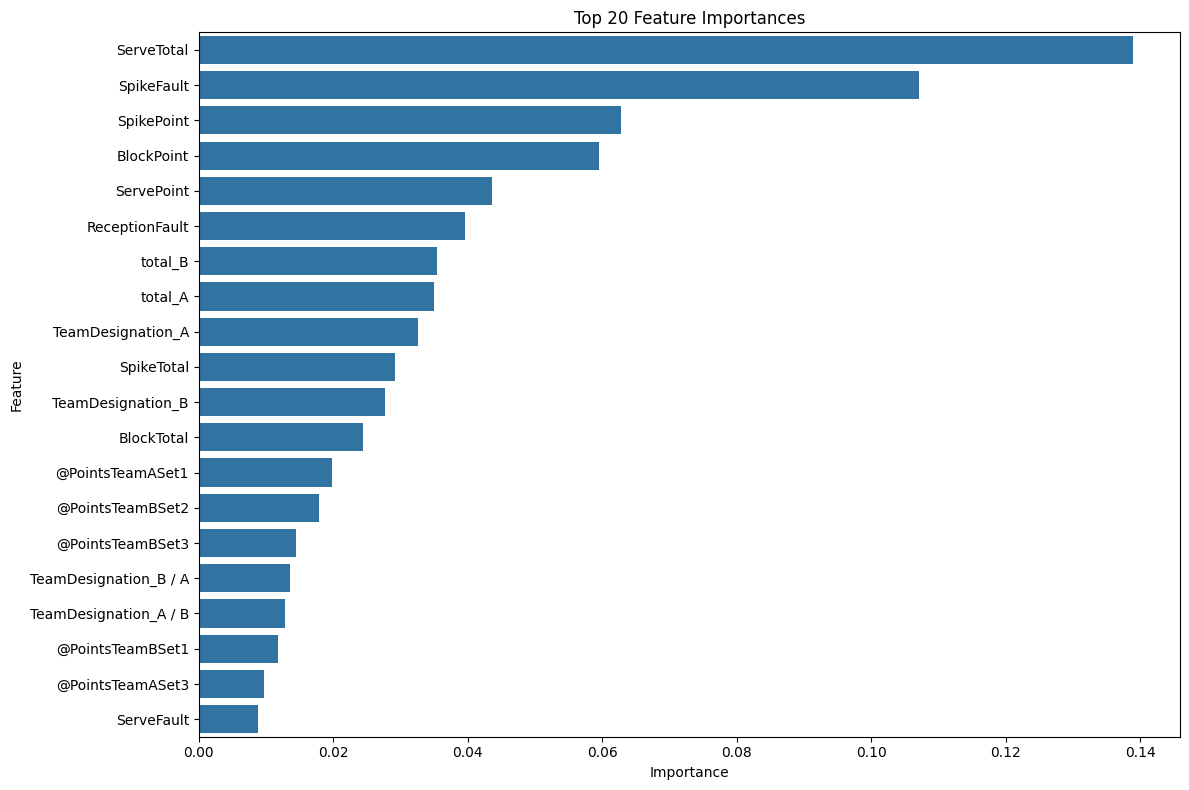

In [49]:
# Get feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'nom':
        ohe = trans.named_steps['onehot']
        feature_names.extend([f"{col}_{cat}" for col in cols 
                            for cat in ohe.categories_[cols.index(col)]])
    else:  # ordinal features
        feature_names.append(name[4:])  # Remove 'ord_' prefix

        # Get and display feature importances
if hasattr(rf_model.named_steps['classifier'], 'feature_importances_'):
    importances = rf_model.named_steps['classifier'].feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure lengths match
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    print(importance_df.head(20))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Feature importance plot saved as 'feature_importance.png'")

In [53]:
#Random Forest

train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

#Gradient Boosting
GB_model = trained_models['GradientBoosting']

train_score1 = GB_model.score(X_train, y_train)
test_score1 = GB_model.score(X_test, y_test)

print(f"Train Accuracy GB: {train_score1:.4f}")
print(f"Test Accuracy GB: {test_score1:.4f}")


Train Accuracy: 0.9451
Test Accuracy: 0.9545
Train Accuracy GB: 1.0000
Test Accuracy GB: 1.0000


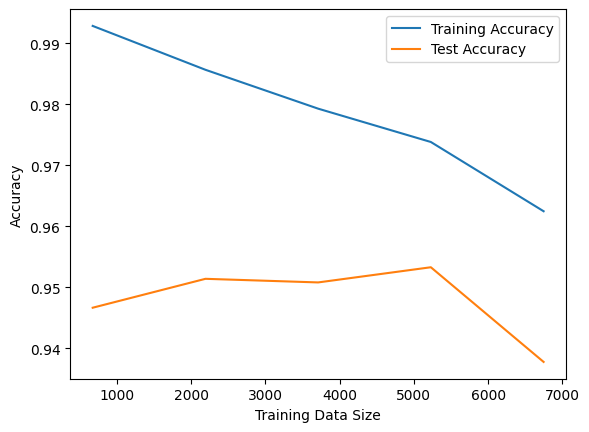

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=5)

# Mittelwerte berechnen
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Test Accuracy")
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
